
Reproducibility Project Notebook Bonus for CS598 DL4H in Spring 2023<br />

Charles Stolz - cstolz2@illinois.edu<br />
Sean Enright - seanre2@illinois.edu<br />


Group ID: 77<br />
Paper ID: 155<br />

Presentation link: https://www.youtube.com/@DL4H_Group77<br />
Code link: https://github.com/rylandtikes/cs598-project<br />
Presentation link: https://youtu.be/LFLJMnoj0mg <br />

This notebook reproduces the research in:

[Variationally Regularized Graph-based Representation Learning for Electronic Health Records](https://arxiv.org/abs/1912.03761)


## Table of Contents:
* [Purpose](#Purpose)
* [Summary of Findings](#Summary-of-Findings)
* [Key Results](#Key-Results)
* [MIMIC-III Data](#MIMIC-III-Data)
* [eICU Data](#eICU-Data)
* [Experiments](#Experiments)
* [References](#References)

# Summary of Findings

## Result 1: Encoder-decoder Mortality Prediction with MIMIC-III

After making minor hyperparameter adjustments to address the memory-intensive nature of this task, we were able to reproduce the authors' results for MIMIC-III well. Performance of the Enc-dec model exceeded the published value by 1.8%, which also supports the claim that the Enc-dec model performs better than the earlier classical and graph-based methods described above. 

## Result 2: Encoder-decoder Readmission Prediction with eICU

Reproducing the eICU data proved more challenging. Our training data shows both inconsistency in the performance of the Enc-dec model on readmission prediction, and overall lower performance than described in the paper. We have included a representative result in our analysis. Using the hyperparameters reported in the paper, performance of the Enc-dec model was lower than the authors' result by 7.5%. Furthermore, its performance is worse than all of the competing methods described by the authors. By modifying the weight of the L2 norm penalty term, performance improved significantly, but was still 3.0% lower than the reported value. The performance of this model is superior to all three classical methods, but is inferior to the Transformer and GCT models, contrary to Claim 2. 


## Result 3: Variational Regularization Improves Performance Over Encoder-decoder

The performance of the VGNN model supports Claim 3, i.e., that the model improves over the Enc-dec network, but this result only holds for MIMIC-III data. The performance on eICU data has proven to consistently lower than that of Enc-dec, despite extensive hyperparameter experiments, contrary to the claim. The performance of the VGNN matches the authors' result within 1.3% for the MIMIC-III prediction task after modifying batch size to address memory concerns.
However, the representative performance of VGNN on the eICU prediction task falls short of the published result by 13.4% using the hyperparameters listed in the paper, a difference similar to the result seen in the Enc-dec network on this dataset. Our optimizations to the hyperparameters improved model performance, but still fell behind the published value by 10.0%.




# MIMIC-III Data

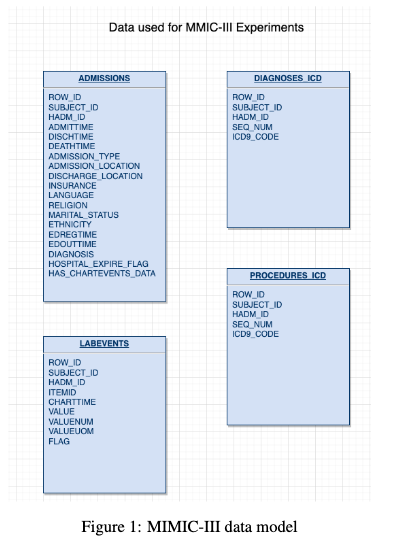




# eICU Data

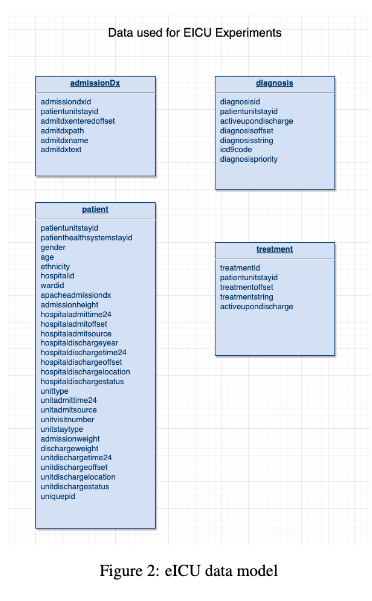

# Key Results
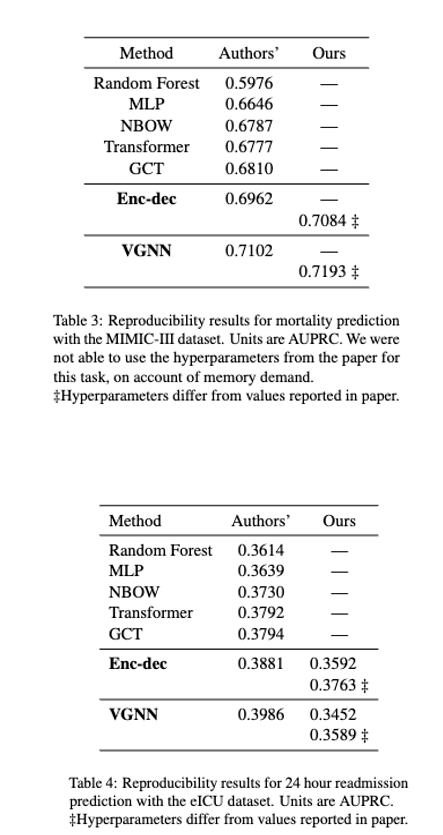

In [ ]:
"""
Clone the project Git Repo if needed. Preprocessed eICU and MIMIC-III data will be needed for training
Scripts to create the datasets available under /data of below repo
"""

#!git clone https://github.com/rylandtikes/cs598-project.git

In [ ]:
# Verify files downloaded
!ls

# Experiments
Execute the below code to reproduce the experiments

In [ ]:
# Install Dependencies
%pip install numpy
%pip install pandas
%pip install protobuf
%pip install scikit_learn
%pip install scipy
%pip install tensorflow
%pip install torch
%pip install tqdm
%pip install pyyaml


In [ ]:
import argparse
import torch
import numpy as np
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from collections import Counter
import pickle
from tqdm import tqdm
from datetime import datetime
import os
import logging
import torch.nn.functional as F
from sklearn.metrics import precision_recall_curve, auc
from torch.utils.data import Dataset
import copy
import csv
from pathlib import Path
import yaml
import shutil

In [ ]:
# Verify Nvidia Drivers setup (optional uncomment if desired)
# !nvidia-smi

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

In [ ]:
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

In [ ]:
# Verify available memory on GPU
print(torch.cuda.memory_summary(device=0, abbreviated=False))

In [ ]:
# model

def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


def clone_params(param, N):
    return nn.ParameterList([copy.deepcopy(param) for _ in range(N)])


class Regularized(torch.nn.Module):
    """Wrapper of PyTorch module to allow regularization calculations to be performed on gradient 
       for more efficient computation.

       Hook-based approach adapted from regularization module in
       https://github.com/szymonmaszke/torchlayers
    """
    def __init__(self, module, norm_type='l2', weight_decay=0):
        super().__init__()
        self.module = module
        self.weight_decay = weight_decay
        if norm_type not in ('l2', 'l1'):
            raise ValueError('Unsupported norm type')
        self.regularize = self.l1 if norm_type=='l1' else self.l2
        # Backward hook is registered on the specified module
        self.hook = self.module.register_full_backward_hook(self._weight_decay_hook)

    def _weight_decay_hook(self, *_):
        """Applies regularization to each parameter in module at gradient level.
        """
        for param in self.module.parameters():
            param.grad = self.regularize(param)

    def l1(self, parameter):
        """Calculates L1 norm for a given module parameter.

        Args:
            parameter (torch.nn.parameter.Parameter): module parameter

        Returns:
            torch.Tensor: updated gradient after regularization
        """
        return self.weight_decay * torch.sign(parameter.data)
    
    def l2(self, parameter):
        """Calculates L2 norm for a given module parameter.

        Args:
            parameter (torch.nn.parameter.Parameter): module parameter

        Returns:
            torch.Tensor: updated gradient after regularization
        """
        return self.weight_decay * parameter.data

    def forward(self, *args, **kwargs):
        """Forward pass returns inner module's own forward method.

        Returns:
            torch.nn.Module: inner module
        """
        return self.module(*args, **kwargs)


class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2


class GraphLayer(nn.Module):

    def __init__(self, in_features, hidden_features, out_features, num_of_nodes,
                 num_of_heads, dropout, alpha, concat=True):
        super(GraphLayer, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.out_features = out_features
        self.alpha = alpha
        self.concat = concat
        self.num_of_nodes = num_of_nodes
        self.num_of_heads = num_of_heads
        # Attention
        # Linear layers for multi-head attention
        self.W = clones(
            nn.Linear(in_features, hidden_features),
            num_of_heads
            )
        # Parameters for multi-head attention
        self.a = clone_params(
            nn.Parameter(torch.rand(size=(1, 2 * hidden_features)), requires_grad=True),
            num_of_heads
            )
        self.leakyrelu = nn.LeakyReLU(self.alpha)

        # FFN applied after attention
        self.linear = nn.Linear(hidden_features, out_features)
        if concat:
            self.ffn = nn.Sequential(
                nn.Dropout(dropout),
                LayerNorm(hidden_features),
                nn.ELU()
            )
        else:
            self.ffn = nn.Sequential(
                nn.Dropout(dropout),
                LayerNorm(hidden_features),
                nn.ReLU(),
                self.linear
            ) 

    def initialize(self, init_method=nn.init.xavier_normal_):
        """Set initial weights in model.
        """
        for i in range(len(self.W)):
            init_method(self.W[i].weight.data)
        for i in range(len(self.a)):
            init_method(self.a[i].data)
        if not self.concat:
            init_method(self.linear.weight.data)

    def attention(self, linear, a, data, edges):
        """Updates representation by graph propagation with self-attention.

            Uses 'Method 2': the inner product of a learnable vector and the concatenation of two
            relevant representations.

        Args:
            linear (torch.Module): linear layer
            a (torch.Parameter): parameters of attention
            data (torch.Tensor): representation of EHR codes,
                                 of shape (self.num_of_nodes, embedding dim)
            edge (torch.Tensor): edge connectivity vector for observed codes, of shape (2, v_obs^2)

        Returns:
            torch.Tensor: updated representation of EHR codes after attenention from graph
        """
        data = linear(data).unsqueeze(0)
        # h: self.num_of_nodes x out
        h = torch.cat(
            (data[:, edges[0, :], :],
             data[:, edges[1, :], :]), dim=0)
        data = data.squeeze(0)
        # edge_h: 2*D x E
        edge_h = torch.cat(
            (h[0, :, :],
             h[1, :, :]), dim=1).transpose(0, 1)
        # d_h: dimensionality of embedding dimension
        d_h = np.sqrt(self.hidden_features * self.num_of_heads)
        # edge_e: E
        edge_e = torch.exp(self.leakyrelu(a.mm(edge_h).squeeze()) / d_h)
        edge_e = torch.sparse_coo_tensor(
            edges.to(device),
            edge_e.to(device),
            torch.Size([self.num_of_nodes, self.num_of_nodes])
            )
        e_rowsum = torch.sparse.mm(edge_e, torch.ones(size=(self.num_of_nodes, 1)).to(device))
        # e_rowsum: N x 1
        row_check = (e_rowsum == 0)
        e_rowsum[row_check] = 1
        zero_idx = row_check.nonzero()[:, 0]
        edge_e = edge_e.add(torch.sparse.FloatTensor(
                               zero_idx.repeat(2, 1),
                               torch.ones(len(zero_idx)).to(device),
                               torch.Size([self.num_of_nodes, self.num_of_nodes])
                               ))
        # edge_e: E
        h_prime = torch.sparse.mm(edge_e, data)
        # h_prime: N x out
        h_prime.div_(e_rowsum)
        return h_prime

    def forward(self, edges, data=None):
        """Uses fully connected graph to update representation of EHR codes via self-attention.

        Args:
            edge (torch.Tensor): edge connectivity vector for observed codes, of shape (2, v_obs^2)
            data (torch.Tensor): representation of EHR codes,
                                 of shape (self.num_of_nodes, embedding dim)

        Returns:
            torch.Tensor: updated representation of EHR codes
        """
        # If using multi-head attention (self.num_of_heads > 1), compute attention coeffs multiple
        # times. If is input layer (self.concat), aggregate coeffs by concatenation.
        attn_list = []
        for w, a in zip(self.W, self.a):
            attn_out = self.attention(w, a, data, edges)
            attn_list.append(attn_out)
        if self.concat:
            h_prime = torch.cat(attn_list, dim=1)
        else:
            h_prime = torch.stack(attn_list, dim=0).mean(dim=0)
        # FFN
        return self.ffn(h_prime)


class VariationalGNN(nn.Module):
    """Graph-based neural network. Encoder-decoder (Enc-dec) or variationally regulated (VGNN).
    """

    def __init__(self, in_features, out_features, num_of_nodes, n_heads, n_layers,
                 dropout, alpha, variational=True, excluded_features=0, mask_prob=0):
        super(VariationalGNN, self).__init__()
        self.variational = variational
        self.num_of_nodes = num_of_nodes + 1 - excluded_features
        self.out_features = out_features
        self.n_heads = n_heads
        self.dropout = nn.Dropout(dropout)
        self.excluded_features = excluded_features
        self.mask_prob = mask_prob

        # Encoder
        self.embed = nn.Embedding(self.num_of_nodes, in_features, padding_idx=0)
        self.in_att = clones(
            GraphLayer(in_features, in_features, in_features, self.num_of_nodes,
                       n_heads, dropout, alpha, concat=True),
            n_layers)
        
        # Variational regularization
        self.parameterize = nn.Linear(out_features, out_features * 2)

        # Decoder
        self.out_att = GraphLayer(in_features, in_features, out_features, self.num_of_nodes,
                                  n_heads, dropout, alpha, concat=False)
        decoder_output_size = out_features
        if excluded_features > 0:
            decoder_output_size = out_features + out_features // 2
            self.features_ffn = nn.Sequential(
                nn.Linear(excluded_features, out_features // 2),
                nn.ReLU(),
                nn.Dropout(dropout)
                )
        self.out_layer = nn.Sequential(
            nn.ReLU(),
            nn.Linear(decoder_output_size, out_features),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(out_features, 1)
            )
        
        # Initialize encoder graph layers
        for i in range(n_layers):
            self.in_att[i].initialize()
        self.out_att.initialize()

    @staticmethod
    def make_fc_graph_edges(nodes):
        """Creates a graph connectivity vector in COO format for a complete undirected graph from
           a given set of nodes.

        Args:
            nodes (torch.Tensor): nodes of shape (n)

        Returns:
            torch.Tensor: graph connectivity vector in COO format
        """
        n = nodes.size()[1]
        source = nodes.repeat(1, n) # non-zero nodes in order, repeated n times
        dest = nodes.repeat(n, 1).transpose(0, 1).contiguous().view((1, n ** 2))
        return torch.cat((source, dest), dim=0)

    def data_to_edges(self, codes):
        """Creates input and output graph connectivity vectors in COO format from a set of nodes.
           Both graphs are complete and undirected. The output graph consists of the input graph
           and one additional node for prediction.

           While training, to improve the robustness of the model dealing with sparse data,
           observed codes will be removed with variable probability.

        Args:
            codes (torch.Tensor): tensor of EHR codes for a single patient

        Returns:
            (torch.Tensor, torch.Tensor): input and output graph connectivity in COO format
        """
        n = codes.size()[0]
        observed = codes.nonzero() # observed EHR codes, of shape (num_nonzero, 1)
        if observed.size()[0] == 0:
            return torch.LongTensor([[0], [0]]), torch.LongTensor([[n + 1], [n + 1]])
        if self.training:
            # Exclude observed codes with 0.05 probability
            mask = torch.rand(observed.size()[0])
            mask = mask > self.mask_prob
            observed = observed[mask]
            if observed.size()[0] == 0:
                return torch.LongTensor([[0], [0]]), torch.LongTensor([[n + 1], [n + 1]])
        # Input edges
        # Nodes, of shape (1, n), incremented by 1
        observed = observed.transpose(0, 1) + 1
        input_edges = self.make_fc_graph_edges(observed)
        # Output edges
        # Adds a node at the end with value n + 1. Will act as prediction node.
        observed = torch.cat((observed, torch.LongTensor([[n + 1]]).to(device)), dim=1)
        output_edges = self.make_fc_graph_edges(observed)

        return input_edges.to(device), output_edges.to(device)

    def reparameterize(self, mu, logvar):
        """Sample latent variables from distribution to become input to decoder. Used in
           variational regularization.

        Args:
            mu (torch.Tensor): mean
            logvar (torch.Tensor): variance

        Returns:
            torch.Tensor: samples of latent distribution
        """
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def encoder_decoder(self, codes):
        """Passes batch through the Encoder-decoder network

            First, embeddings of medical concepts are made.
            Medical embeddings are processed by the encoder to form the graph representation. In
            each graph layer, the graph representation is updated via self-attention.
            If variational, a latent layer is added between the encoder and decoder to regularize
            the graph representation.
            The output of the encoder is then passed through the decoder, which consists of one
            layer and self-attention. The output is the representation of the predictive node.

        Args:
            codes (torch.Tensor): EHR codes for one patient of shape (num codes)

        Returns:
            (torch.Tensor, torch.Tensor): inference from decoder output of shape (embedding_dim)
                                          and KL divergence
        """
        # Embedding of medical concepts
        # h_prime: (num_of_nodes, embedding_dim)
        h_prime = self.embed(torch.arange(self.num_of_nodes).long().to(device))
        # Encoder
        # input_edges: input graph edge connection matrix of fully-connected nodes after masking
        # output_edges: output graph edge connection matrix of input nodes and one additional node
        input_edges, output_edges = self.data_to_edges(codes)
        for attn in self.in_att:
            h_prime = attn(input_edges, h_prime)
        # If variational regularization is used, add linear layer and sample distribution
        if self.variational:
            h_prime = self.parameterize(h_prime).view(-1, 2, self.out_features)
            h_prime = self.dropout(h_prime)
            mu = h_prime[:, 0, :]
            # The variance is parameterized as an exponential to ensure non-negativity
            logvar = h_prime[:, 1, :]
            h_prime = self.reparameterize(mu, logvar)
            mu = mu[codes, :]
            logvar = logvar[codes, :]
        # Decoder
        # The last row of h_prime is the representation of an additional node for prediction
        h_prime = self.out_att(output_edges, h_prime)
        out = h_prime[-1]
        # If applying variational regularization, KL divergence is needed
        if self.variational:
            kld = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2)) / mu.size()[0]
        else:
            kld = torch.tensor(0.0).to(device)
        return out, kld

    def forward(self, batch):
        """Forward pass of VGNN or Enc-dec network.

           Steps:
           Pass nodes for each patient in batch through Encoder-decoder network, giving the
           prediction task embedding from the decoder output and the KL divergence.
           Determine logits (unnormalized predictions) concatenating the decoder output for all
           patients and passing through ReLU and a FFN (self.out_layer).
           Sum KL divergence for all patients.

           If any features are excluded from the graph, they are separated, and pass through
           self.features_ffn and then joined with the encoder-decoder output, which acts on the
           non-excluded features.

        Args:
            batch (torch.Tensor): batch of shape (batch size, num nodes)

        Returns:
            (torch.Tensor, torch.Tensor): logits and KL divergence
        """
        kld_batch = []
        included_batch = []
        if self.excluded_features == 0:
            for i in range(batch.size()[0]):
                out, kld = self.encoder_decoder(batch[i, :])
                included_batch.append(out)
                kld_batch.append(kld)
                out_batch = torch.stack(included_batch)
        else:
            excluded_batch = []
            for i in range(batch.size()[0]):
                out, kld = self.encoder_decoder(batch[i, self.excluded_features:])
                included_batch.append(out)
                kld_batch.append(kld)
                excluded_nodes = torch.FloatTensor([batch[i, :self.excluded_features]]).to(device)
                excluded_batch.append(self.features_ffn(excluded_nodes))
            out_batch = torch.cat((torch.stack(excluded_batch), torch.stack(included_batch)),
                                  dim=1)
        logits = self.out_layer(out_batch)
        kld_sum = torch.sum(torch.stack(kld_batch))
        return logits, kld_sum

In [ ]:
# Utils

def train(data, model, optim, criterion, kl_scale, max_clip_norm=5):
    """Trains model for one batch and reports loss.

    Args:
        data (torch.Tensor): batch of shape (batch size, num nodes)
        model (torch.nn.Module): model being used to train
        optim (torch.optim): optimizer to hold state and update parameters based on gradients
        criterion: loss function
        kl_scale (float): weight of KL divergence term
        max_clip_norm (int, optional): maximum norm of gradient before it is clipped. Defaults to 5.

    Returns:
        (float, float, float): loss, KL divergence and BCE loss after model training pass
    """
    #model.train()
    # The last code is the label
    input = data[:, :-1].to(device)
    label = data[:, -1].float().to(device)
    # Training
    model.train()
    optim.zero_grad()
    logits, kld = model(input)
    # Loss considers binary cross-entropy and weighted KL divergence
    logits = logits.squeeze(-1)
    kld = kld.sum()
    bce = criterion(logits, label)
    loss = bce + kl_scale * kld
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_clip_norm)
    loss.backward()
    optim.step()
    return loss.item(), kld.item(), bce.item()


def evaluate(model, data_iter, length):
    model.eval()
    y_pred = np.zeros(length)
    y_true = np.zeros(length)
    y_prob = np.zeros(length)
    pointer = 0
    for data in data_iter:
        input = data[:, :-1].to(device)
        label = data[:, -1]
        batch_size = len(label)
        probability, _ = model(input)
        probability = torch.sigmoid(probability.squeeze(-1).detach())
        predicted = probability > 0.5
        y_true[pointer: pointer + batch_size] = label.numpy()
        y_pred[pointer: pointer + batch_size] = predicted.cpu().numpy()
        y_prob[pointer: pointer + batch_size] = probability.cpu().numpy()
        pointer += batch_size
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    return auc(recall, precision), (y_pred, y_prob, y_true)


class EHRData(Dataset):
    def __init__(self, data, cla):
        self.data = data
        self.cla = cla

    def __len__(self):
        return len(self.cla)

    def __getitem__(self, idx):
        return self.data[idx], self.cla[idx]


def collate_fn(data):
    # padding
    data_list = []
    for datum in data:
        data_list.append(np.hstack((datum[0].toarray().ravel(), datum[1])))
    return torch.from_numpy(np.array(data_list)).long()        



In [ ]:
# Change values here if using notebook configuration

reg_options = ["l2", "l1", "none"]

config_dict = {
    "batch_size": 32,
    "data_path": "./eicu-data/",
    "dropout": 0.4,
    "embedding_size": 128,
    "eval_freq": 1,
    "excluded_features": 0,
    "leaky_relu_alpha": 0.1,
    "lr": 0.0001,
    "manual_seed": 0,
    "mask_prob": 0.1,
    "num_of_epochs": 1,
    "num_of_heads": 1,
    "num_of_layers": 2,
    "overwrite_save": False,
    "reg_method": "l1",
    "reg_weight": 1e-2,
    "result_path": "./Enc-Dec_L1/",
    "save_model": True,
    "test": True,
    "upsample_factor": 2,
    "var": False,
    "var_scale": 1.0,
    "weight_decay": 1e-2,
}


# Change to True to use a local configuration file instead of notebook
read_configuration_from_file = True

local_config_file = "./train_mimic_none.yaml"
if read_configuration_from_file:
    with open(local_config_file, mode="rt", encoding="utf-8") as file_handle:
        config_dict = yaml.safe_load(file_handle)


# The values below should not be changed.
################################################################################
batch_size = config_dict["batch_size"]
# input path of processed dataset
data_path = config_dict["data_path"]
dropout = config_dict["dropout"]
embedding_size = config_dict["embedding_size"]
eval_freq = config_dict["eval_freq"]
excluded_features = config_dict["excluded_features"]
leaky_relu_alpha = config_dict["leaky_relu_alpha"]
# learning rate
lr = config_dict["lr"]
manual_seed = config_dict["manual_seed"]
mask_prob = config_dict["mask_prob"]
num_of_epochs = config_dict["num_of_epochs"]
# number of attention heads
num_of_heads = config_dict["num_of_heads"]
# number of graph layers
num_of_layers = config_dict["num_of_layers"]
overwrite_save = config_dict["overwrite_save"]
# regularization
reg_method = config_dict["reg_method"]
reg_weight = float(config_dict["reg_weight"])
# output path of model checkpoints
result_path = config_dict["result_path"]
save_model = config_dict["save_model"]
test = config_dict["test"]
upsample_factor = config_dict["upsample_factor"]
var = config_dict["var"]
var_scale = config_dict["var_scale"]
weight_decay = float(config_dict["weight_decay"])

in_features = embedding_size
out_features = embedding_size
################################################################################


gradient_max_norm = 5  # clip gradient to prevent exploding gradient
# Name of the configuration file written to result path
config_file = "config.yaml"

if manual_seed >= 0:
    torch.manual_seed(manual_seed)

# Load data and upsample training data
train_x, train_y = None, None
if test:
    train_x, train_y = pickle.load(open(data_path + "test_csr.pkl", "rb"))
else:
    train_x, train_y = pickle.load(open(data_path + "train_csr.pkl", "rb"))
    train_upsampling = np.concatenate(
        (
            np.arange(len(train_y)),
            np.repeat(np.where(train_y == 1)[0], upsample_factor - 1),
        )
    )
    train_x = train_x[train_upsampling]
    train_y = train_y[train_upsampling]
val_x, val_y = pickle.load(open(data_path + "validation_csr.pkl", "rb"))

# Configure logging
model_name = f"VGNN_{var_scale}" if var else "Enc-dec"
reg_name = "" if reg_method == "none" else f"reg_{reg_method}_{reg_weight}"
result_folder = (
    f"{model_name}-{reg_name}-lr_{lr}-dropout_{dropout}-"
    f"embed_{in_features}-batch_{batch_size}"
)
if test:
    result_folder += "-TEST"
result_root = Path(result_path) / result_folder
result_root.mkdir(exist_ok=True, parents=True)

# Write config file
with open(result_root / config_file, mode="wt", encoding="utf-8") as cf:
    yaml.dump(config_dict, cf)

for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
logging.basicConfig(
    filename=result_root / "train.log",
    format="%(asctime)s %(message)s",
    level=logging.INFO,
)
dataset_name = "test" if test else "training"
logging.info(f"Begin training with {dataset_name} dataset...")
# csv
csv_fields = ["Epoch", "AUPRC", "Loss", "BCE", "KLD"]
csv_log = open(result_root / "train.csv", "wt", encoding="utf-8", buffering=1)
csv_writer = csv.DictWriter(csv_log, delimiter=",", fieldnames=csv_fields)
csv_writer.writeheader()

# initialize models
num_of_nodes = train_x.shape[1] + 1
device_ids = range(torch.cuda.device_count())

# eICU has 1 feature on previous readmission that we didn't include in the graph
model = VariationalGNN(
    in_features,
    out_features,
    num_of_nodes,
    num_of_heads,
    num_of_layers - 1,
    dropout=dropout,
    alpha=leaky_relu_alpha,
    variational=var,
    excluded_features=excluded_features,
    mask_prob=mask_prob,
).to(device)
if reg_method != "none":
    model = Regularized(model, reg_method, reg_weight)
model = nn.DataParallel(model, device_ids=device_ids)
val_loader = DataLoader(
    dataset=EHRData(val_x, val_y),
    batch_size=batch_size,
    collate_fn=collate_fn,
    num_workers=torch.cuda.device_count(),
    shuffle=False,
)
optimizer = optim.AdamW(
    [p for p in model.parameters() if p.requires_grad], lr=lr, weight_decay=weight_decay
)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Train models
for epoch in range(num_of_epochs):
    train_loader = DataLoader(
        dataset=EHRData(train_x, train_y),
        batch_size=batch_size,
        collate_fn=collate_fn,
        num_workers=torch.cuda.device_count(),
        shuffle=True,
    )
    # BCE Loss is weighted by positive-negative ratio
    counter = Counter(train_y)
    ratio = counter[True] / counter[False]
    pos_weight = torch.ones(1).float().to(device) * ratio
    criterion = nn.BCEWithLogitsLoss(reduction="sum", pos_weight=pos_weight)

    # Configure logging within epoch
    print(f'Epoch: {epoch + 1}, Learning rate: {optimizer.param_groups[0]["lr"]}')
    num_batches = len(train_loader)
    last_batch = num_batches - 1
    update_interval = max(round(num_batches / 20.0, 0), 1)

    # Iterate through batches within epoch
    model.train()
    total_loss = np.zeros(3)
    t = tqdm(iter(train_loader), leave=False, total=last_batch, unit="batch")
    for idx, batch_data in enumerate(t):
        # Train model on batch
        loss, kld, bce = train(
            batch_data, model, optimizer, criterion, var_scale, gradient_max_norm
        )
        total_loss += np.array([loss, bce, kld])
        if idx > 0:
            curr_loss = total_loss[0] / idx
            curr_bce = total_loss[1] / idx
            curr_kld = total_loss[2] / idx
        # Report training progress within batch via tqdm
        if (idx % update_interval == 0 or idx == last_batch) and idx > 0:
            progress = (
                f"Loss: {curr_loss:.4f}, BCE: {curr_bce:.4f}, KLD: {curr_kld:.4f}"
            )
            t.set_description(progress)
            t.refresh()
        # Save model's state dictionary to file
        if save_model and idx == last_batch and not test:
            param_file = (
                "parameter"
                if overwrite_save
                else f"parameter-epoch_{epoch}-batch_{idx}"
            )
            torch.save(model.state_dict(), result_root / param_file)
        # Evaluate and log training
        if idx == last_batch and (epoch + 1) % eval_freq == 0:
            val_auprc, _ = evaluate(model, val_loader, len(val_y))
            prog = {
                "Epoch": epoch + 1,
                "AUPRC": f"{val_auprc:.4f}",
                "Loss": f"{curr_loss:.4f}",
                "BCE": f"{curr_bce:.4f}",
                "KLD": f"{curr_kld:.4f}",
            }
            csv_writer.writerow(prog)
            eval_log = (
                f'Epoch: {prog["Epoch"]}, AUPRC: {prog["AUPRC"]}, '
                f'Loss: {prog["Loss"]}, BCE: {prog["BCE"]}, KLD: {prog["KLD"]}'
            )
            logging.info(eval_log)
            print(f"AUPRC: {val_auprc:.4f}")
    scheduler.step()
csv_log.close()


In [ ]:
# Compress the results and copy to Google drive if desired
'''
from google.colab import drive
drive.mount('/content/drive')
'''


In [ ]:
!ls {result_path}/{result_folder}

In [ ]:
!cat {result_path}/{result_folder}/config.yaml


In [ ]:
!cat {result_path}/{result_folder}/train.csv

# References


Edward Choi, Zhen Xu, Yujia Li, Michael W. Dusen-
  berry, Gerardo Flores, Yuan Xue, and Andrew M. Dai.
  2019. Graph convolutional transformer: Learning
  the graphical structure of electronic health records.
  CoRR, abs/1906.04716.

Alistair E.W. Johnson, Tom J. Pollard, Lu Shen, Li-
  wei H. Lehman, Mengling Feng, Mohammad Ghas-
  semi, Benjamin Moody, Peter Szolovits, Leo An-
  thony Celi, Roger G. Mark, and et al. 2016. Mimic-
  iii, a freely accessible critical care database. Scien-
  tific Data, 3(1).

Tom J. Pollard, Alistair E. Johnson, Jesse D. Raffa,
  Leo A. Celi, Roger G. Mark, and Omar Badawi.
  2018. The eicu collaborative research database, a
  freely available multi-center database for critical care
  research. Scientific Data, 5(1).

Charles Stolz and Sean Enright. 2023. Cs598:
  Deep learning for healthcare reproducibility
  project. https://github.com/rylandtikes/
  cs598-project.

Weicheng Zhu and Narges Razavian. 2021. Variation-
  ally regularized graph-based representation learning
  for electronic health records. In Proceedings of
  the Conference on Health, Inference, and Learning,
  CHIL ’21, page 1–13, New York, NY, USA. Associa-
  tion for Computing Machinery.

